In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/khongtrunght/tranferBiggan.git 

Cloning into 'tranferBiggan'...
remote: Enumerating objects: 398, done.
remote: Counting objects: 100% (398/398), done.
remote: Compressing objects: 100% (326/326), done.
remote: Total 398 (delta 63), reused 398 (delta 63), pack-reused 0
Receiving objects: 100% (398/398), 33.26 MiB | 21.97 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [4]:
cd tranferBiggan

/content/tranferBiggan


In [ ]:
%%capture
!sudo apt-get install git-lfs
!git lfs pull

In [ ]:
!git lfs pull 
!unzip data/afhq.zip -d data

Training

In [12]:
!python train.py --dataset animal --gpu 0 --pretrained ./data/G_ema.pth  --step 21600 --step-facter 0.2 --iters 180000 --eval-freq 3000

gpu id: 0
using device: cuda:0
made the log directory ./experiments/train_dataset-animal_model-biggan128-ada_2021-12-29-14-27-05
cannot import gitpython; try pip install gitpython
number of images (dataset size):  360
model name: biggan128-ada
Adding attention layer in G at resolution 64
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
0 train loss: 37.62128 | smoothed loss 37.62128 
100 train loss: 24.66797 | smoothed loss 30.07594 
200 train loss: 22.76001 | smoothed loss 23.72170 
300 train

Testing

In [44]:
data_size = 360
import glob
import os
import matplotlib
from PIL import Image
import numpy as np
import json

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torchvision
from models.setup_model import setup_model
from dataloaders.setup_dataloader_smallgan import setup_dataloader


from scipy.stats import truncnorm


def reconstruct(model, out_path, indices_labels, add_small_noise=False):
    with torch.no_grad():
        model.eval()
        device = next(model.parameters()).device
        dataset_size = model.embeddings.weight.size()[0]
        indices, labels = indices_labels
        if type(indices) != torch.Tensor:
            indices = torch.tensor(indices, device=device)
            labels = torch.tensor(labels, device=device)
        assert type(indices) == torch.Tensor
        indices = indices.to(device)
        embeddings = model.embeddings(indices)
        batch_size = embeddings.size()[0]

        # labels = [0, ] * batch_size
        # labels = torch.tensor(labels, device=device)
        labels = labels.to(device)
        labels_embeddings = model.linear(labels)

        if add_small_noise:
            embeddings += torch.randn(embeddings.size(), device=device)*0.01
        image_tensors = model(embeddings, labels_embeddings)
        return image_tensors

# see https://github.com/nogu-atsu/SmallGAN/blob/2293700dce1e2cd97e25148543532814659516bd/gen_models/ada_generator.py#L37-L53


def interpolate(model, out_path, source, dist, trncate=0.4, num=5, label=0):
    with torch.no_grad():
        model.eval()
        device = next(model.parameters()).device
        dataset_size = model.embeddings.weight.size()[0]
        indices = torch.tensor([source, dist], device=device)
        indices = indices.to(device)
        embeddings = model.embeddings(indices)
        embeddings = embeddings[[0]] * torch.linspace(1, 0, num, device=device)[
            :, None] + embeddings[[1]] * torch.linspace(0, 1, num, device=device)[:, None]

        batch_size = embeddings.size()[0]

        labels = [label, ] * batch_size
        labels = torch.tensor(labels, device=device)
        labels_embeddings = model.linear(labels)

        image_tensors = model(embeddings, labels_embeddings)
        return image_tensors

# from https://github.com/nogu-atsu/SmallGAN/blob/2293700dce1e2cd97e25148543532814659516bd/gen_models/ada_generator.py#L37-L53


def random(model, out_path, tmp=0.4, n=9, truncate=True):
    with torch.no_grad():
        model.eval()
        device = next(model.parameters()).device
        dataset_size = model.embeddings.weight.size()[0]
        dim_z = model.embeddings.weight.size(1)
        if truncate:
            embeddings = truncnorm(-tmp, tmp).rvs(n *
                                                  dim_z).astype("float32").reshape(n, dim_z)
        else:
            embeddings = np.random.normal(
                0, tmp, size=(n, dim_z)).astype("float32")
        embeddings = torch.tensor(embeddings, device=device)
        batch_size = embeddings.size()[0]

        labels = [0, 0, 0, 1, 1, 1, 2, 2, 2]
        labels = torch.tensor(labels, device=device)
        label_embeddings = model.linear(labels)

        image_tensors = model(embeddings, label_embeddings)
        return image_tensors


In [17]:
dataloader = setup_dataloader("animal",batch_size=2)
dataset_size = len(dataloader.dataset)
exp_dir = "./experiments/train_dataset-animal_model-biggan128-ada_2021-12-29-14-27-05/"
print(json.load(open(exp_dir+"args.json")))
model = setup_model("biggan128-ada",dataset_size=data_size,resume=exp_dir+"checkpoint_iter21000.pth.tar")
model = model.cuda()

{'batch': 25, 'dataset': 'animal', 'eval_freq': 3000, 'githash': None, 'gpu': '0', 'iters': 180000, 'loss_dist_per': 'l2', 'loss_emd': 0.1, 'loss_norm_img': 1, 'loss_norm_per': 1, 'loss_per': 0.1, 'loss_re': 0.02, 'lr_bsa_l': 0.0005, 'lr_c_embed': 0.001, 'lr_embed': 0.05, 'lr_g_batch_stat': 0.0005, 'lr_g_l': 1e-07, 'model': 'biggan128-ada', 'pretrained': './data/G_ema.pth', 'print_freq': 100, 'resume': None, 'savedir': 'train', 'saveroot': './experiments', 'step': 21600, 'step_facter': 0.2, 'workers': 4}
model name: biggan128-ada
Adding attention layer in G at resolution 64
resuming trained weights from ./experiments/train_dataset-animal_model-biggan128-ada_2021-12-29-14-27-05/checkpoint_iter21000.pth.tar


In [18]:
%%capture 
model.eval()

In [19]:
to_pil = torchvision.transforms.ToPILImage()
to_mul_pic_nor = lambda x : to_pil(torchvision.utils.make_grid(x, normalize=True)) 

In [20]:
test_cho = reconstruct(model, "test/reconstruct.png", [[15,16,17,18], [1,1,1,1]])
test_meo = reconstruct(model, "test/reconstruct.png", [[15,16,17,18], [0,0,0,0]])
test_wild = reconstruct(model, "test/reconstruct.png", [[39,40,41,42], [2,2,2,2]])

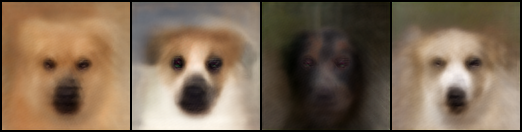

In [21]:
to_mul_pic_nor(test_cho)

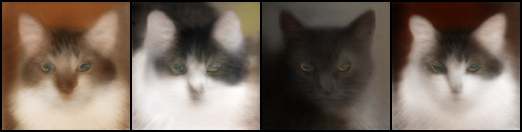

In [22]:
to_mul_pic_nor(test_meo)

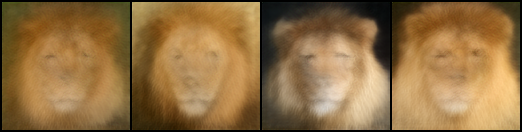

In [23]:
to_mul_pic_nor(test_wild)

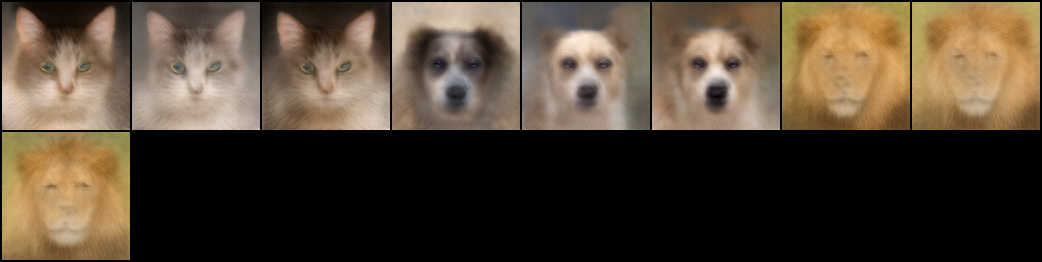

In [24]:
to_mul_pic_nor(random(model, "fasd", tmp=0.2, n=9, truncate=True))

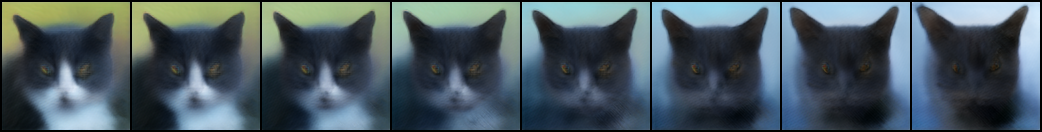

In [26]:
to_mul_pic_nor(interpolate(model, "abc", 2, 8, trncate=0.1, num=8))

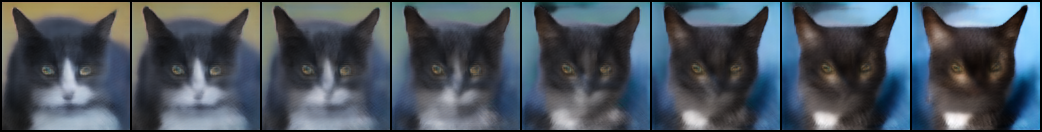

In [39]:
to_mul_pic_nor(interpolate(model2, "abc", 2, 8, trncate=0.1, num=8))

In [ ]:
labels = [0, 0, 0, 1, 1, 1, 2, 2, 2]
labels = torch.tensor(labels).cuda()
label_embeddings = model.linear(labels)

#model2

In [28]:
model2 = setup_model("biggan128-ada",dataset_size=data_size,resume=exp_dir+"checkpoint_iter120000.pth.tar")
model2 = model2.cuda().eval()

model name: biggan128-ada
Adding attention layer in G at resolution 64
resuming trained weights from ./experiments/train_dataset-animal_model-biggan128-ada_2021-12-29-14-27-05/checkpoint_iter120000.pth.tar


In [35]:
test_cho2 = reconstruct(model2, "test/reconstruct.png", [[15,16,17,18], [1,1,1,1]])
test_meo2 = reconstruct(model2, "test/reconstruct.png", [[15,16,17,18], [0,0,0,0]])
test_wild2 = reconstruct(model2, "test/reconstruct.png", [[15,16,17,18], [2,2,2,2]])

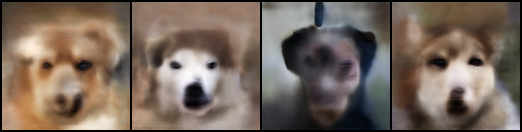

In [36]:
to_mul_pic_nor(test_cho2)

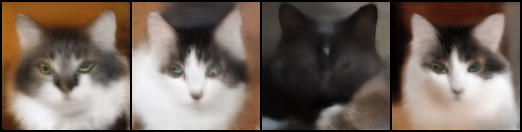

In [37]:
to_mul_pic_nor(test_meo2)

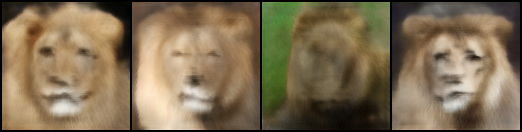

In [38]:
to_mul_pic_nor(test_wild2)

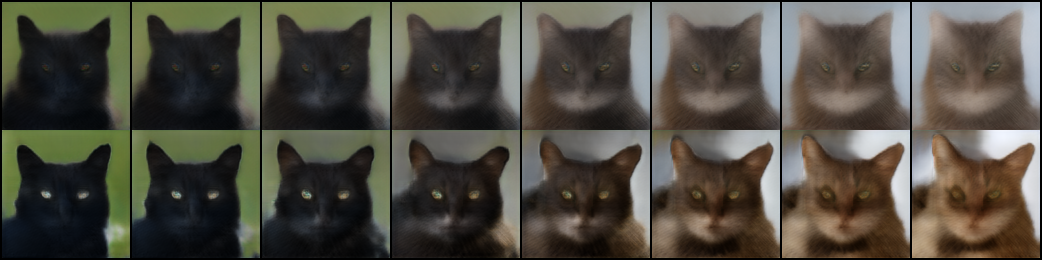

In [40]:
tren = interpolate(model, "abc", 100, 103, trncate=0.1, num=8)
duoi = interpolate(model2, "abc", 100, 103, trncate=0.1, num=8)
to_mul_pic_nor(torch.cat([tren, duoi], dim=2))

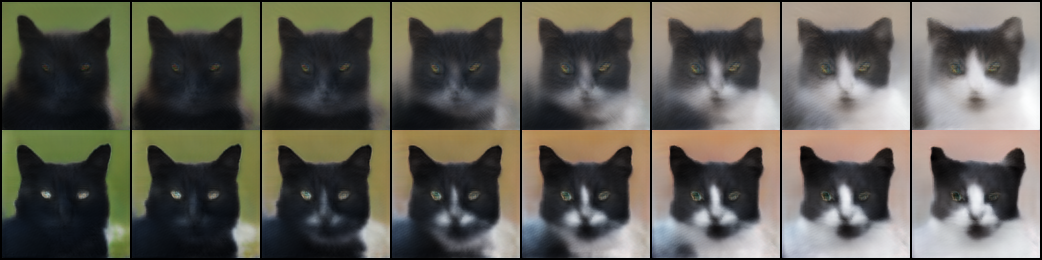

In [41]:
tren = interpolate(model, "abc", 100, 200, trncate=0.1, num=8)
duoi = interpolate(model2, "abc", 100, 200, trncate=0.1, num=8)
to_mul_pic_nor(torch.cat([tren, duoi], dim=2))

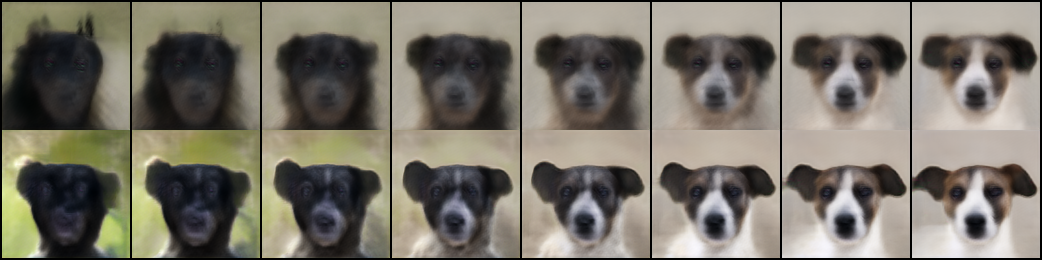

In [45]:
tren = interpolate(model, "abc", 100, 200, trncate=0.1, num=8, label=1)
duoi = interpolate(model2, "abc", 100, 200, trncate=0.1, num=8, label=1)
to_mul_pic_nor(torch.cat([tren, duoi], dim=2))

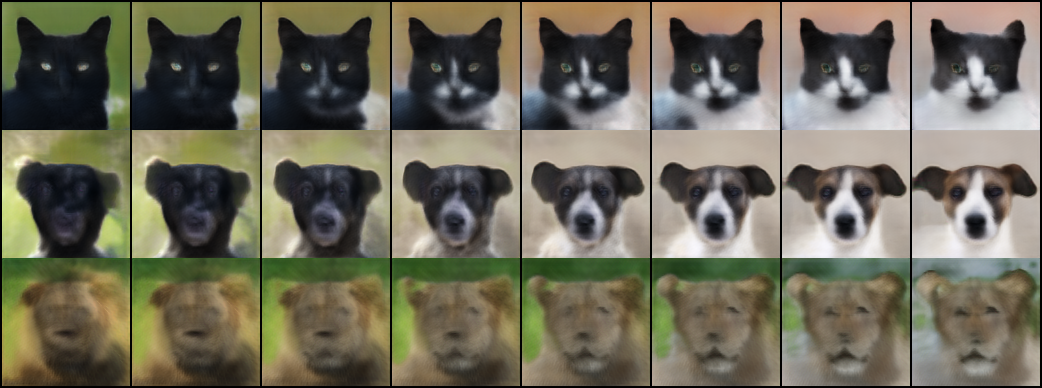

In [50]:
tren = interpolate(model2, "abc", 100, 200, trncate=0.1, num=8)
giua = interpolate(model2, "abc", 100, 200, trncate=0.1, num=8, label=1)
duoi = interpolate(model2, "abc", 100, 200, trncate=0.1, num=8, label=2)
to_mul_pic_nor(torch.cat([tren, giua,duoi], dim=2))

In [55]:
def inter_3class(source, dist):
  tren = interpolate(model2, "abc", source, dist, trncate=0.1, num=8)
  giua = interpolate(model2, "abc", source, dist, trncate=0.1, num=8, label=1)
  duoi = interpolate(model2, "abc", source, dist, trncate=0.1, num=8, label=2)
  return to_mul_pic_nor(torch.cat([tren, giua,duoi], dim=2))

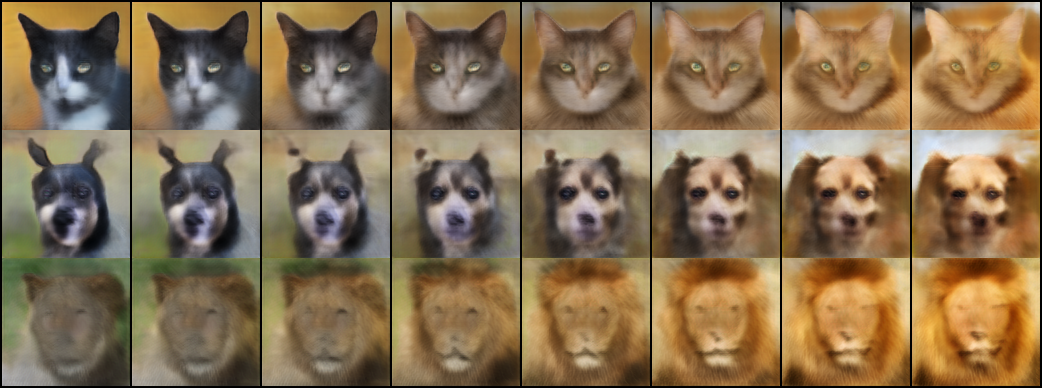

In [56]:
inter_3class(1, 30)

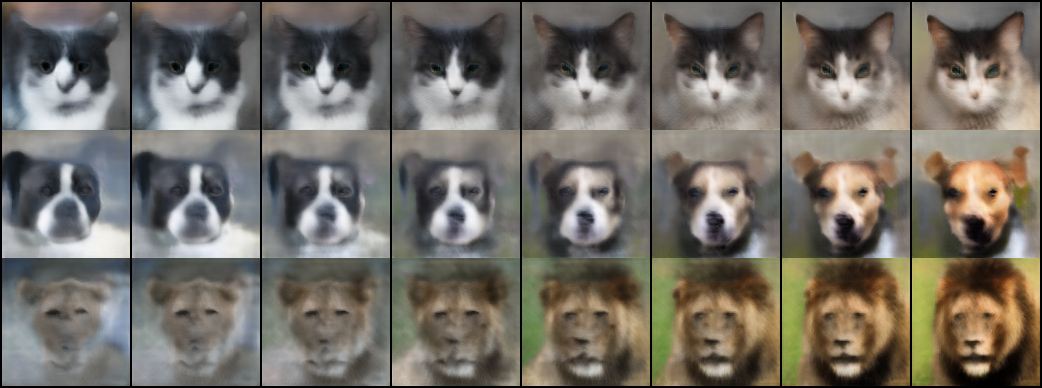

In [60]:
inter_3class(210, 250)

In [62]:
!cp /content/tranferBiggan/experiments/train_dataset-animal_model-biggan128-ada_2021-12-29-14-27-05/checkpoint_iter120000.pth.tar /content/drive/MyDrive/project_team_9